In [1]:
import os
import imghdr
from imutils import *

### 1.采集人脸

In [3]:
'''
function: 对样本图片进行人脸采集
params:
    image 样本图片
    outPut 采集人脸的输出路径
'''
def faceDetect(image, outPut):
    #图片名称
    name = os.path.basename(image)
    #读取图片
    image = imread(image)
    #转换为灰度
    image = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    
    detector = cv2.CascadeClassifier('haarcascade_frontalface_alt.xml')
    rects = detector.detectMultiScale(image, scaleFactor = 1.1, minNeighbors = 3, minSize = (10,10), flags = cv2.CASCADE_SCALE_IMAGE)
    for (x,y,w,h) in rects:
        face_image = cv2.resize(image[y:y+h, x:x+w], (200,200))
        cv2.imwrite(os.path.join(outPut, name), face_image)

In [4]:
def predict_face(path, outPut):
    #输出图片路径不存在，则创建文件夹
    if not os.path.exists(outPut):
        os.makedirs(outPut)
    
    for file in os.listdir(path):
        #检测是否为存放图片的文件夹
        if os.path.isdir(os.path.join(path, file)):
            outPut2 = os.path.join(outPut, file)
            #创建存放图片的子文件夹
            if not os.path.exists(outPut2):
                os.makedirs(outPut2)
                
            file_path = os.path.join(path, file)
            for image_path in os.listdir(file_path):
                image = os.path.join(file_path, image_path)
                faceDetect(image, outPut2)

In [5]:
predict_face('train_faces', 'predict_faces')

### 2.生产标签文件

In [9]:
def make_label(path):
    with open('label.txt', 'w') as fh:
        #表示人脸的标签
        label = 0
        for root, dirs, files in os.walk(path):
            #遍历每个子文件夹
            for subDir in dirs:
                subDir_path = os.path.join(root, subDir)
                #遍历子文件夹下的每一张图片
                for file in os.listdir(subDir_path):
                    image_path = os.path.join(subDir_path, file)
                    #判断图片类型
                    imgType = imghdr.what(image_path)
                    if imgType == 'jpeg' or imgType == 'png':
                        fh.write(image_path)
                        fh.write(':')
                        fh.write(str(label))
                        fh.write('\n')
                label += 1

In [10]:
make_label('predict_faces')

### 3.训练模型数据

In [13]:
images = []
labels = []
with open('label.txt') as fh:
    for line in fh:
        arrLine = line.split(':')
        image = cv2.imread(arrLine[0], 0)
        images.append(image)
        labels.append(int(arrLine[1]))

#定义人脸识别模型
model = cv2.face.EigenFaceRecognizer_create()
model.train(np.array(images), np.array(labels))
#保存训练模型数据
model.save('predict_face_deng_tm_yao.xml')

### 4.人脸识别

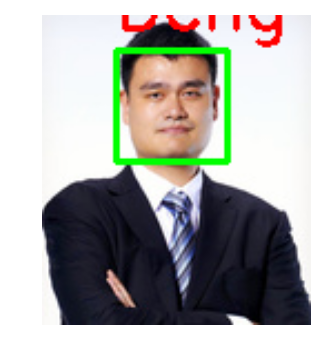

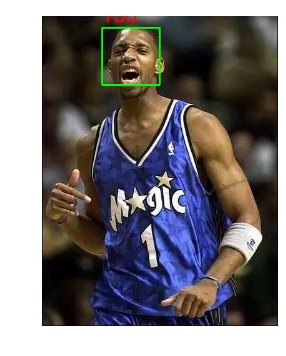

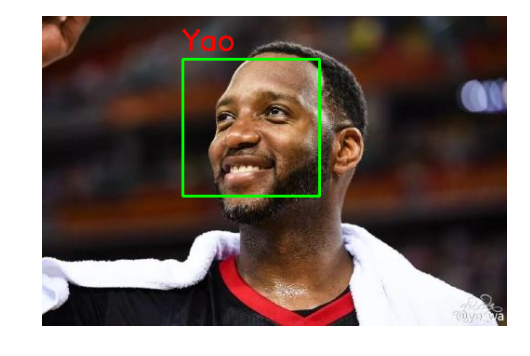

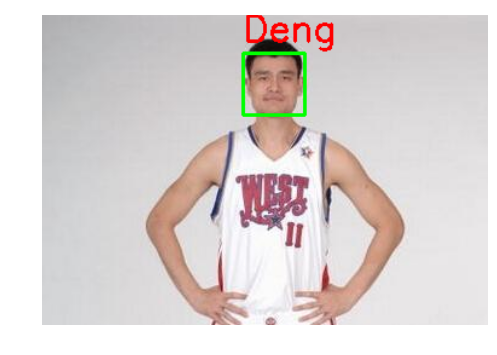

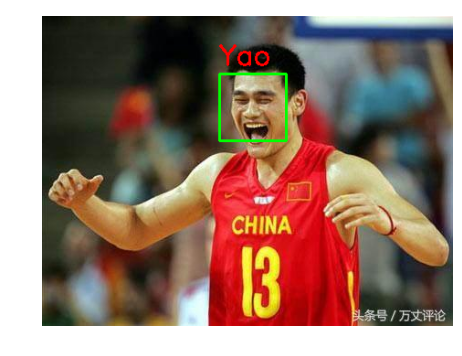

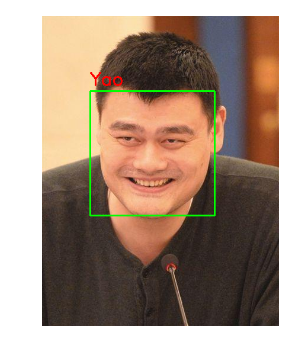

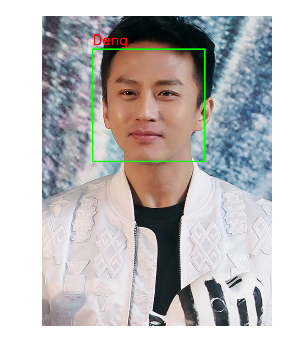

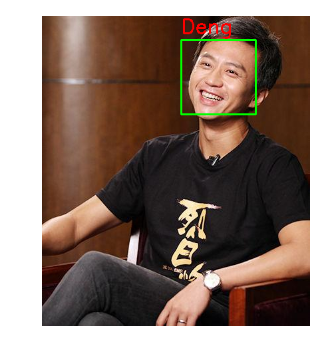

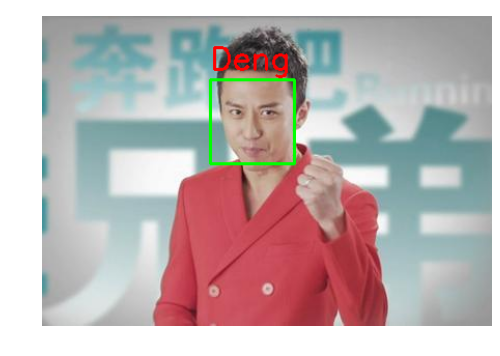

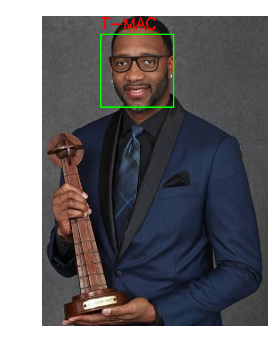

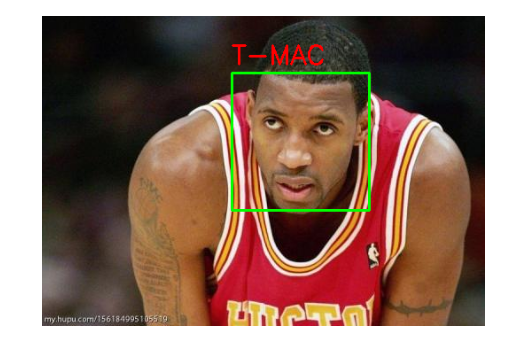

In [21]:
name = ['Deng', 'T-MAC', 'Yao']
#载入训练后后的模型
model = cv2.face.EigenFaceRecognizer_create()
model.read('predict_face_deng_tm_yao.xml')


for file in os.listdir('test'):
    image = os.path.join('test', file)
    imgType = imghdr.what(image)
    if imgType == 'jpeg' or imgType == 'png':
        image = imread(image)
        gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
        detector = cv2.CascadeClassifier('haarcascade_frontalface_alt.xml')
        rects = detector.detectMultiScale(gray, scaleFactor = 1.1, minNeighbors = 3, minSize = (10,10), flags = cv2.CASCADE_SCALE_IMAGE)
        for (x,y,w,h) in rects:
            cv2.rectangle(image, (x,y), (x+w,y+h), (0,255,0), 2)
            face = cv2.resize(gray[y:y+h,x:x+w], (200,200))
            params = model.predict(face)
            #params[0] 表示相应的标签
            cv2.putText(image, name[params[0]], (x,y-10), cv2.FONT_HERSHEY_SIMPLEX, 1, (255,0,0), 2)
        show(image)